# This notebook presents a tutorial introduction to qucircuit

Install qucircuit

In [ ]:
# comment the following if already installed
%pip install qucircuit>=2.0

# An end-to-end walk-trhough from creating a circuit to seeing outputs

In [1]:
import qckt
import qckt.backend as bknd
import numpy as np

## First let us create a simple ghz circuit

In [2]:
circuit = qckt.QCkt(3,3, 'A simple Ghz circuit')  # 3-qubits register, and 3 classical bits register to store the measured values

circuit.H(0)
circuit.CX(0,1)
circuit.CX(1,2)
circuit.draw()

# another way to visualize the circuit is to list it - less graphical, but more compact
circuit.list()

A simple Ghz circuit
q000 -[H]-[.]-----
           |      
q001 -----[X]-[.]-
               |  
q002 ---------[X]-
                  
creg =============
                  
A simple Ghz circuit
H[0]
CX[0, 1]
CX[1, 2]


## ... and add measurement operation

In [3]:
circuit.M([2,1,0])
circuit.draw()
circuit.list()

A simple Ghz circuit
q000 -[H]-[.]-----[M]-
           |       |  
q001 -----[X]-[.]-[M]-
               |   |  
q002 ---------[X]-[M]-
                   |  
creg ==============v==
                      
A simple Ghz circuit
H[0]
CX[0, 1]
CX[1, 2]
M[2, 1, 0][2, 1, 0]


## Exploring the backend services
We go though the long way, and then the short way

In [4]:
# The long way:
# Now, to run it lets first see what all backend service providers are available here. (spoiler alert - only 1 service provider is configured in the default deployment)
reg = bknd.Registry()
svc_list = reg.listSvc()
print(f'List of service providers - {svc_list}')

# now, pick the first (only) service, and list out the engines on that service
bksvc = reg.getSvc(svcName=svc_list[0][0])
eng_list = bksvc.listInstances()
print(f'List of backend engines - {eng_list}')

# lets use the second in this list, with the name 'qsim-deb'
eng_touse = eng_list[1]
print(f'Using engine - {eng_touse}')

# finally, fetch the handle to this engine
bkeng = bksvc.getInstance(eng_touse)
print('Backend engine object:', bkeng)

# The short way:
# Note, having gone through this once, and seeing the engines available, you can directly get the handle to the engine as it is exposed in the qckt.backend namespace
bkeng = bknd.Qdeb()
print('Backend engine object:', bkeng)

List of service providers - [('QSystems', 'qsim simulator from Quantum Systems')]
List of backend engines - ['qsim-eng', 'qsim-deb', 'dmqsim-eng', 'dmqsim-deb']
Using engine - qsim-deb
Backend engine object: <qckt.backend.QSystems.Qdeb object at 0x7fde4b10fd00>
Backend engine object: <qckt.backend.QSystems.Qdeb object at 0x7fde4b10fc40>


## Running the circuit by directly using an engine -- Qdeb

In [5]:
# first, create a job object
job = qckt.Job(circuit,qtrace=True)

# get a handle for the Qdeb backend service
bkeng = bknd.Qdeb()

# and now run this job on the backend engine
bkeng.runjob(job)

# Note, we used a debugging backend engine, which honors `qtrace` set to `True` in the Job, hence we see the trace of the execution of the circuit.


Initial State
000    1.00000000+0.00000000j
CREGISTER: 000

H Qubit[0]
000    0.70710678+0.00000000j
001    0.70710678+0.00000000j
CREGISTER: 000

CX Qubit[0, 1]
000    0.70710678+0.00000000j
011    0.70710678+0.00000000j
CREGISTER: 000

CX Qubit[1, 2]
000    0.70710678+0.00000000j
111    0.70710678+0.00000000j
CREGISTER: 000

MEASURED Qubit[2, 1, 0] = [0, 0, 0] with probability = 0.5
000    1.00000000+0.00000000j
CREGISTER: 000


## Results readout
Lets now read out the classical bits values based on the measurement performed.

In [6]:
creg = job.get_creg()
print(f'Measured value of qubits = {creg[0]}')

print(f'Integer value of measured value = {creg[0].intvalue}')

Measured value of qubits = 000
Integer value of measured value = 0


you should see either a 000 or a 111 readout.


## Now, lets run 1000 shots on engine Qeng, and see the results
Now, let us use Qeng, the non-debugging backend and run 1000 shots and see the statistics of the readouts

In [7]:
job = qckt.Job(circuit,shots=1000)

bkeng = bknd.Qeng()
bkeng.runjob(job)

creg_counts = job.get_counts()
print(creg_counts)

[493, 0, 0, 0, 0, 0, 0, 507]


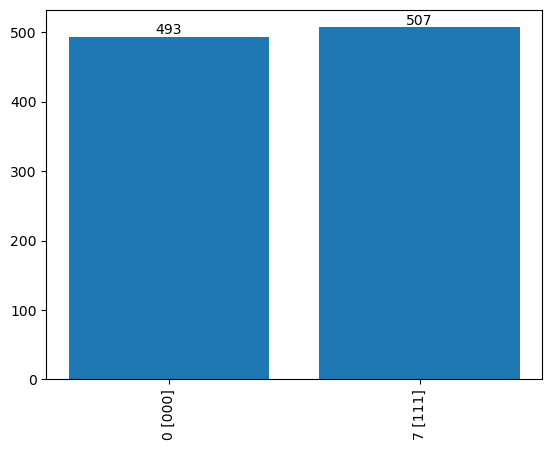

[493, 0, 0, 0, 0, 0, 0, 507]

In [8]:
# or we could see the counts visually
job.plot_counts()

## Execution stats
Finally, let us see the overall stats of the execution of this circuit

In [9]:
job.print_runstats()

Total Ops  :     4      operations
Per Operation:
    H           1 times
    CX          2 times
    MEASURE     1 times


## Overall summary
what we did overall is the following

q000 -[H]-[.]-----[M]-
           |       |  
q001 -----[X]-[.]-[M]-
               |   |  
q002 ---------[X]-[M]-
                   |  
creg ==============v==
                      
Readout counts = [501, 0, 0, 0, 0, 0, 0, 499]


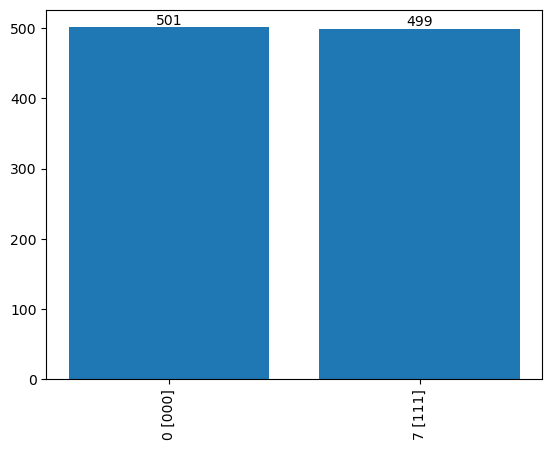

Thats it!


In [10]:
# Created the circuit
circuit = qckt.QCkt(3,3)
circuit.H(0)
circuit.CX(0,1)
circuit.CX(1,2)
circuit.M([2,1,0])
circuit.draw()

# Created a run job with execution config parameters
job = qckt.Job(circuit,shots=1000)

# Ran it on a backend
bkeng = bknd.Qeng()
bkeng.runjob(job)

# Displayed the readout
creg_counts = job.get_counts()
print(f'Readout counts = {creg_counts}')
job.plot_counts()
print('Thats it!')

# Now, let us explore some aspects of how we create circuits on qucircuit

## Single-qubit gates can be applied to multiple qubits in one instruction

In [11]:
# To apply H gate on multiple qubits, we could apply it on individual qubits as below
circuit = qckt.QCkt(4,4)
circuit.H(0)
circuit.H(1)
circuit.H(2)
circuit.H(3)
circuit.draw()
print()


# a shortcut is allowed in qucircuit to 'broadcast' the 1-qubit gates on multiple qubits as below
circuit = qckt.QCkt(4,4)
circuit.H([0,1,2,3])
circuit.draw()

q000 -[H]-------------
                      
q001 -----[H]---------
                      
q002 ---------[H]-----
                      
q003 -------------[H]-
                      
creg =================
                      

q000 -[H]-
          
q001 -[H]-
          
q002 -[H]-
          
q003 -[H]-
          
creg =====
          


In [12]:
# Same holds for parameterized 1-qubit gates

pi = np.pi

# using P gate for this illustration
circuit = qckt.QCkt(4,4)
circuit.P(pi/4.0, 0)
circuit.draw()

# add on 3 more qubits using the shortcut to broadcast it on those qubits
print('with additional gates')
circuit.P(pi/4,[1,2,3])
circuit.draw()

q000 -[P]-
          
q001 -----
          
q002 -----
          
q003 -----
          
creg =====
          
with additional gates
q000 -[P]-----
              
q001 -----[P]-
              
q002 -----[P]-
              
q003 -----[P]-
              
creg =========
              


## User defined gates

### All gates available can be seen using `qckt.get_gates_list()`

In [13]:
# list out the gates supported on this circuit
gates_list = qckt.get_gates_list()
print(gates_list)

['NOISE', 'X', 'Y', 'Z', 'H', 'CX', 'CY', 'CZ', 'CCX', 'SWAP', 'M', 'Border', 'Probe', 'QFT', 'RND', 'P', 'CP', 'UROTk', 'CROTk', 'Rx', 'CRx', 'Ry', 'CRy', 'Rz', 'CRz']


### Additional gates can be added using the `define_gate()` mechanism

In [14]:
# define a user defined gate - a 2-qubit Identity gate with name myIdent
qckt.define_gate(gate_name='myIdent', opMatrix=np.matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], dtype=complex))

circuit = qckt.QCkt(2,2)
# and then use it like other gates
circuit.myIdent(1,0)
circuit.draw()

# Note that the user defined gates are also listed by the get_gates_list()
gates_list = qckt.get_gates_list()
print('List of gates:', gates_list)

q000 -[myIdent L]-
      |         | 
q001 -[myIdent M]-
                  
creg =============
                  
List of gates: ['NOISE', 'X', 'Y', 'Z', 'H', 'CX', 'CY', 'CZ', 'CCX', 'SWAP', 'M', 'Border', 'Probe', 'QFT', 'RND', 'P', 'CP', 'UROTk', 'CROTk', 'Rx', 'CRx', 'Ry', 'CRy', 'Rz', 'CRz', 'myIdent']


M and L are marks to indicate the most-significant and least-significant qubits of the gate.

## Appending circuits
Circuits can sometimes be logically developed in segments and then the overall circuit created by appending them. `circuit.append(other_circuit)` allows appending circuits like this.

`append()` leaves the two original circuits unmodified, and returns a new circuit created by appending the two.

In [15]:
ckt_1 = qckt.QCkt(2,2,name="circuit-1")
ckt_1.H(0)
ckt_1.CX(0,1)
ckt_1.draw()

ckt_2 = qckt.QCkt(2,2,name="circuit-2")
ckt_2.CX(0,1)
ckt_2.H(0)
ckt_2.draw()

circuit = ckt_1.append(ckt_2,name='appended circuit')
circuit.draw()

circuit-1
q000 -[H]-[.]-
           |  
q001 -----[X]-
              
creg =========
              
circuit-2
q000 -[.]-[H]-
       |      
q001 -[X]-----
              
creg =========
              
appended circuit
q000 -[H]-[.]-[.]-[H]-
           |   |      
q001 -----[X]-[X]-----
                      
creg =================
                      


## Realigning qubits in a circuit, and resizing a circuit
`realign()` leaves the original circuit unmodified, and creates a new circuit per the arguments

In [16]:
# the sequence of qubits can be changed and the size of the circuit increased using realign()
circuit = qckt.QCkt(2,2,name='original circuit')
circuit.H(0)
circuit.CX(0,1)
circuit.draw()
print()  # print one line space

# change the size, and sequence of qubits
circ_realigned = circuit.realign(3,3, [1,2], name='realigned circuit')
circ_realigned.draw()

original circuit
q000 -[H]-[.]-
           |  
q001 -----[X]-
              
creg =========
              

realigned circuit
q000 ---------
              
q001 -----[X]-
           |  
q002 -[H]-[.]-
              
creg =========
              


## Converting a circuit into a single operator matrix

In [17]:
# write a circuit to create a bell state
ckt = qckt.QCkt(2,2)
ckt.H(0)
ckt.CX(0,1)
# get an operator matrix of that circuit
opMatrix = ckt.to_opMatrix()

# create a user defined gate using that operator matrix, and use it
qckt.define_gate('BELL', opMatrix=opMatrix)

circuit = qckt.QCkt(2,2)
circuit.BELL(0,1)

# run the circuit using Qdeb() to see the trace of execution and verify the operator matrix
job = qckt.Job(circuit=circuit, qtrace=True)
bk = bknd.Qdeb()
bk.runjob(job=job)


Initial State
00    1.00000000+0.00000000j
CREGISTER: 00

BELL Qubit[0, 1]
00    0.70710678+0.00000000j
11    0.70710678+0.00000000j
CREGISTER: 00


## Using `circuit.Probe()` with `Qdeb()` backend
`circuit.Probe()` allows looking at the state-vector at specific steps in the circuit. So, is better to use insetad of using `job(...,qtrace=True)`, which can provide a flood of trace information.

`Probe()` can be used to probe specific states in the state-vector, details in documentation.

In [18]:
circuit = qckt.QCkt(2,2)
circuit.H(0)
circuit.CX(0,1)
circuit.Probe(header='at bell state')
circuit.CX(0,1)
circuit.H(0)
circuit.Probe(header='at undone bell state')
circuit.draw()

job = qckt.Job(circuit=circuit)
bk = bknd.Qdeb()
bk.runjob(job=job)


q000 -[H]-[.]--v-[.]-[H]--v-
           |   v  |       v 
q001 -----[X]--v-[X]------v-
               v          v 
creg ==========v==========v=
               v          v 

PROBE: at bell state
00    0.70710678+0.00000000j
11    0.70710678+0.00000000j
CREGISTER: 00

PROBE: at undone bell state
00    1.00000000+0.00000000j
CREGISTER: 00


## `Border()` to help with readability of circuit drawings
`Border()` draws vertical partitions on the circuit drawings to help demarcate sections of the circuit for readability

In [19]:
circuit = qckt.QCkt(2,2)
circuit.H(0)
circuit.CX(0,1)
circuit.Border()
circuit.CX(0,1)
circuit.H(0)
circuit.draw()

q000 -[H]-[.]--#-[.]-[H]-
           |   #  |      
q001 -----[X]--#-[X]-----
               #         
creg ==========#=========
               #         
